# Preprocessing + Baseline 1: TF-IDF = LogRegression


In [ ]:
import random, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, average_precision_score
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier


In [ ]:
# reproducibility
random.seed(42)
np.random.seed(42)

df = pd.read_csv('fake_news_full_data.csv', index_col=0)

# exclude date feature (to avoid leakage)
df = df.drop(columns=["date"], errors="ignore")

df["title"] = df["title"].fillna("").astype(str)
df["text"]  = df["text"].fillna("").astype(str)
df["text_all"] = df["title"] + " [SEP] " + df["text"]

print("Before drop_duplicates:", len(df))

df_clean = df.drop_duplicates(subset="text_all").reset_index(drop=True)
#print("After  drop_duplicates:", len(df_clean))

X = df_clean["text_all"]
y = df_clean["is_fake"].values
print("shape:", df_clean.shape, "| class balance:", df_clean["is_fake"].value_counts(normalize=True).round(3).to_dict())


Before drop_duplicates: 44680
shape: (39100, 4) | class balance: {0: 0.542, 1: 0.458}


Train/validation split + pipeline (TF-IDF → Logistic Regression)

In [ ]:
# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF
vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=1,
    max_df=1.0,
    strip_accents="unicode"
    #stop_words="english"
)

Xtr = vectorizer.fit_transform(X_train)  # fit only for train
Xva = vectorizer.transform(X_val)

In [ ]:
# Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(Xtr, y_train)
pred = model.predict(Xva)

Evaluation (F1, report, confusion matrix)


In [ ]:
f1m = f1_score(y_val, pred, average="macro")
f1w = f1_score(y_val, pred, average="weighted")
print(f"Baseline TFIDF+LogReg → F1-macro={f1m:.3f} | F1-weighted={f1w:.3f}\n")
print(classification_report(y_val, pred, digits=3))

cm = pd.DataFrame(confusion_matrix(y_val, pred),
                  index=["real(0)","fake(1)"],
                  columns=["pred_real(0)","pred_fake(1)"])
cm

Baseline TFIDF+LogReg → F1-macro=0.986 | F1-weighted=0.986

              precision    recall  f1-score   support

           0      0.981     0.994     0.987      4239
           1      0.993     0.977     0.985      3581

    accuracy                          0.986      7820
   macro avg      0.987     0.985     0.986      7820
weighted avg      0.986     0.986     0.986      7820



,pred_real(0),pred_fake(1)
real(0),4213,26
fake(1),83,3498


In [ ]:
pd.Series(pred).value_counts()

,count
0,4296
1,3524


In [ ]:
pd.Series(y_val).value_counts()

,count
0,4239
1,3581


In [ ]:
# Feature importance
feat_names = vectorizer.get_feature_names_out()
coefs = model.coef_.ravel()
feature_importance = pd.Series(coefs, index=feat_names, name="coef").sort_values(ascending=False)

top_fake = feature_importance.head(20)                 # positive → contributes to class 1 (fake)
top_real = feature_importance.tail(20).sort_values()   # negative → contributes to class 0 (real)

print("\nTop n-grams for FAKE:\n", top_fake.to_string())
print("\nTop n-grams for REAL:\n", top_real.to_string())


Top n-grams for FAKE:
 video             9.350062
video sep         7.272205
via               7.025668
this              6.728628
is                6.365929
you               5.799747
us                5.704687
that              5.506539
just              5.398997
hillary           5.386096
image             4.593127
obama             4.555096
watch             4.399774
featured          4.291197
gop               4.270438
featured image    4.269061
com               4.030520
image via         3.921865
america           3.878883
read more         3.659905

Top n-grams for REAL:
 said                 -19.148090
reuters              -14.895618
on                    -9.052839
in                    -7.012005
said on               -6.681729
washington reuters    -6.528745
sep washington        -6.495926
washington            -4.968184
on wednesday          -4.845713
on tuesday            -4.453469
on thursday           -4.324081
republican            -4.298332
minister              -4.195

stop-words = (english) reduced F1-macro from 0.986 to 0.984; therefore, stopwords carry useful signal.  
For the baseline we keep `stop_words=None`.


In [ ]:
# probabilities for AUC (LogReg provides them)
proba = model.predict_proba(Xva)[:, 1]

# basic metrics
f1m = f1_score(y_val, pred, average="macro")
f1w = f1_score(y_val, pred, average="weighted")
prec, rec, f1_each, supp = precision_recall_fscore_support(
    y_val, pred, labels=[0,1], average=None
)
cm = confusion_matrix(y_val, pred, labels=[0,1])

row = {
    "model": "tfidf_word12_logreg_baseline",
    "n_val": len(y_val),
    "f1_macro": round(f1m, 6),
    "f1_weighted": round(f1w, 6),
    "precision_0": round(prec[0], 6),
    "recall_0": round(rec[0], 6),
    "precision_1": round(prec[1], 6),
    "recall_1": round(rec[1], 6),
    "tn": int(cm[0,0]), "fp": int(cm[0,1]),
    "fn": int(cm[1,0]), "tp": int(cm[1,1]),
    "roc_auc": round(roc_auc_score(y_val, proba), 6),
    "pr_auc": round(average_precision_score(y_val, proba), 6),
}

os.makedirs("../reports", exist_ok=True)
metrics_path = "../reports/metrics.csv"

new_row = pd.DataFrame([row])
if os.path.exists(metrics_path):
    met = pd.read_csv(metrics_path)
    met = met[met["model"] != row["model"]]           # update existing record of this model
    met = pd.concat([met, new_row], ignore_index=True)
else:
    met = new_row

met.to_csv(metrics_path, index=False)
print("Saved:", metrics_path)


Saved: ../reports/metrics.csv


# Baselaine 2: BoW + LogRegression

In [ ]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

# Tokenization function with stopword removal and stemming
def tokenize(text: str) -> list[str]:
    """
    Tokenize text, remove stopwords, and apply stemming.

    Parameters
    ----------
    text : str
        Input text to be processed.

    Returns
    -------
    list of str
        List of processed tokens: words only, without stopwords,
        reduced to their stems.
    """
    tokens = word_tokenize(text)                         # tokenization
    tokens = [t for t in tokens if t.isalpha()]          # keep words only (exclude numbers/symbols)
    tokens = [t for t in tokens if t not in stop_words]  # remove stopwords
    stems  = [stemmer.stem(t) for t in tokens]           # stemming
    return stems


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Words needed to cover 95% of tokens: 6,988


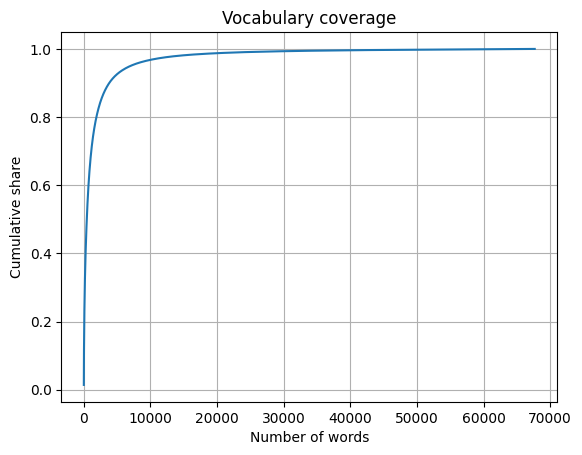

In [ ]:
COVERAGE = 0.95  # can be 0.90–0.98

# count frequencies on train using the same tokenize
cnt = Counter()
for txt in X_train:
    cnt.update(tokenize(txt))

total = sum(cnt.values()) or 1
# most frequent -> cumulative share
items = cnt.most_common()
cum = np.cumsum([c for _, c in items]) / total
optimal_features_95 = int(np.argmax(cum >= COVERAGE) + 1)

print(f"Words needed to cover {int(COVERAGE*100)}% of tokens: {optimal_features_95:,}")

# plot
plt.plot(cum)
plt.xlabel("Number of words")
plt.ylabel("Cumulative share")
plt.title("Vocabulary coverage")
plt.grid(True)
plt.show()


In [ ]:
bow_stem = CountVectorizer(
    tokenizer=tokenize,     # custom tokenizer
    lowercase=True,         # lowercase is applied BEFORE tokenizer
    token_pattern=None,     # disable default pattern (required when using a custom tokenizer,
                            # otherwise CountVectorizer will ignore the custom one)
    ngram_range=(1,2),
    min_df=1, max_df=1.0,
    max_features=7000
)

Xtr_bow_stem = bow_stem.fit_transform(X_train.astype(str))
Xva_bow_stem = bow_stem.transform(X_val.astype(str))


In [ ]:
# Train Logistic Regression on BoW features (with stemming) and evaluate performance
clf_bow_stem = LogisticRegression(max_iter=1000, class_weight="balanced")
clf_bow_stem.fit(Xtr_bow_stem, y_train)
pred_bow_stem = clf_bow_stem.predict(Xva_bow_stem)

f1m_bow_stem = f1_score(y_val, pred_bow_stem, average="macro")
f1w_bow_stem = f1_score(y_val, pred_bow_stem, average="weighted")
print(f"BoW + stopwords + stemming → F1-macro={f1m_bow_stem:.3f} | F1-weighted={f1w_bow_stem:.3f}\n")
print(classification_report(y_val, pred_bow_stem, digits=3))

cm = pd.DataFrame(confusion_matrix(y_val, pred_bow_stem),
                  index=["real(0)","fake(1)"],
                  columns=["pred_real(0)","pred_fake(1)"])
cm


BoW + stopwords + stemming → F1-macro=0.996 | F1-weighted=0.996

              precision    recall  f1-score   support

           0      0.995     0.998     0.996      4239
           1      0.997     0.994     0.996      3581

    accuracy                          0.996      7820
   macro avg      0.996     0.996     0.996      7820
weighted avg      0.996     0.996     0.996      7820



,pred_real(0),pred_fake(1)
real(0),4230,9
fake(1),23,3558


In [ ]:
feat_names_bow = bow_stem.get_feature_names_out()
coefs = clf_bow_stem.coef_.ravel()
feature_importance_bow = pd.Series(coefs, index=feat_names_bow, name="coef").sort_values(ascending=False)

top_fake_bow = feature_importance_bow.head(20)                 # positive → pushes toward class 1 (fake)
top_real_bow = feature_importance_bow.tail(20).sort_values()   # negative → pushes toward class 0 (real)

print("\nTop n-grams for FAKE:\n", top_fake_bow.to_string())
print("\nTop n-grams for REAL:\n", top_real_bow.to_string())



Top n-grams for FAKE:
 video sep       2.191690
via             2.066590
imag            1.529151
sep             1.463074
presid trump    1.202612
break           1.149741
gop             1.132571
hillari         1.127397
imag via        0.914970
us              0.807036
know            0.768516
video           0.689802
america         0.667819
https           0.651363
someth          0.650710
read            0.643913
news            0.627966
realli          0.608471
daili           0.595285
watch           0.592351

Top n-grams for REAL:
 reuter              -6.196315
washington reuter   -1.746867
sep washington      -1.733820
sep reuter          -1.406616
presid donald       -0.978587
reuter presid       -0.855751
wednesday           -0.749019
said                -0.650661
presid barack       -0.639624
friday              -0.614148
told report         -0.604451
london              -0.585682
edt                 -0.582796
thursday            -0.553170
tuesday             -0.529793
ne

**Quality:** F1-macro = 0.996, F1-weighted = 0.996 — excellent result.  
The confusion matrix is symmetric: 15 FP (real→fake) and 15 FN (fake→real). The model is stable across both classes.  

**What the model “learns” (coefficients):**  

- **FAKE↑:** video sep, imag, sep, presid trump, break, gop, hilarri, https, read, watch, america…  
  → Social media style: mentions of videos, links, and political triggers (proper names).  

- **REAL↑ (negative coefficients):** reuter, washington reuter, sep reuter, presid donald, wednesday, told report, london…  
  → Reuters signatures (location/date/day of the week).  

**Conclusion on the data:** the model relies on domain-specific markers of source/style (Reuters vs. clickbait outlets).  
This is not data leakage, but there is a risk of domain bias: performance may degrade on other sources.  


In [ ]:
# LOG: bow_word12_stem_logreg → reports/metrics.csv
# probabilities for AUC
proba = clf_bow_stem.predict_proba(Xva_bow_stem)[:, 1]

# basic metrics
f1m = f1_score(y_val, pred_bow_stem, average="macro")
f1w = f1_score(y_val, pred_bow_stem, average="weighted")
prec, rec, _, _ = precision_recall_fscore_support(y_val, pred_bow_stem, labels=[0,1], average=None)
cm = confusion_matrix(y_val, pred_bow_stem, labels=[0,1])

row = {
    "model": "bow_word12_stem_logreg",
    "n_val": len(y_val),
    "f1_macro": round(f1m, 6),
    "f1_weighted": round(f1w, 6),
    "precision_0": round(prec[0], 6), "recall_0": round(rec[0], 6),
    "precision_1": round(prec[1], 6), "recall_1": round(rec[1], 6),
    "tn": int(cm[0,0]), "fp": int(cm[0,1]),
    "fn": int(cm[1,0]), "tp": int(cm[1,1]),
    "roc_auc": round(roc_auc_score(y_val, proba), 6),
    "pr_auc": round(average_precision_score(y_val, proba), 6),
}

os.makedirs("../reports", exist_ok=True)
mpath = "../reports/metrics.csv"

dfm = pd.read_csv(mpath) if os.path.exists(mpath) else pd.DataFrame(columns=row.keys())
dfm = dfm[dfm["model"] != row["model"]]          # update record if it already exists
dfm = pd.concat([dfm, pd.DataFrame([row])], ignore_index=True)
dfm.to_csv(mpath, index=False)
print("Saved →", mpath)

# view updated table
dfm.sort_values(["f1_macro","f1_weighted"], ascending=False).reset_index(drop=True)


Saved → ../reports/metrics.csv


,model,n_val,f1_macro,f1_weighted,precision_0,recall_0,precision_1,recall_1,tn,fp,fn,tp,roc_auc,pr_auc
0,bow_word12_stem_logreg,7820,0.995877,0.995907,0.994592,0.997877,0.997477,0.993577,4230,9,23,3558,0.998103,0.995936
1,tfidf_word12_logreg_baseline,7820,0.985944,0.986052,0.980680,0.993866,0.992622,0.976822,4213,26,83,3498,0.998477,0.997562


# Model 2 TF-IDF + SVD + XGBoost


In [ ]:
# TF-IDF
tfidf_vec = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    max_features=20000,
    strip_accents="unicode"
)

Xtr_tf = tfidf_vec.fit_transform(X_train.astype(str))
Xva_tf = tfidf_vec.transform(X_val.astype(str))
Xtr_tf.shape, Xva_tf.shape


((31280, 20000), (7820, 20000))

In [ ]:
# Dimensionality reduction: TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=42)
Xtr_svd = svd.fit_transform(Xtr_tf).astype("float32")
Xva_svd = svd.transform(Xva_tf).astype("float32")
Xtr_svd.shape, Xva_svd.shape

((31280, 200), (7820, 200))

In [ ]:
xgb = XGBClassifier(
    tree_method="hist",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)
xgb.fit(Xtr_svd, y_train)

pred = xgb.predict(Xva_svd)
print("F1-macro:", f1_score(y_val, pred, average="macro"))
print(classification_report(y_val, pred, digits=3))

cm = pd.DataFrame(confusion_matrix(y_val, pred),
                  index=["real(0)","fake(1)"],
                  columns=["pred_real(0)","pred_fake(1)"])
cm

F1-macro: 0.9824649615796149
              precision    recall  f1-score   support

           0      0.978     0.990     0.984      4239
           1      0.988     0.974     0.981      3581

    accuracy                          0.983      7820
   macro avg      0.983     0.982     0.982      7820
weighted avg      0.983     0.983     0.983      7820



,pred_real(0),pred_fake(1)
real(0),4196,43
fake(1),93,3488


F1-macro ≈ 0.982.  

Error balance is good: FP=43, FN=93.  

Baseline-2 (BoW+stem+LR) remains the best (~0.996).  

Model-2 (TF-IDF → SVD → XGB, k=200) is a strong alternative model for comparison.  


In [ ]:
# LOG: tfidf_svd_xgb_n1000_k200 → reports/metrics.csv
# if predictions are not available yet — calculate them
pred_xgb = xgb.predict(Xva_svd)
proba_xgb = xgb.predict_proba(Xva_svd)[:, 1]

f1m = f1_score(y_val, pred_xgb, average="macro")
f1w = f1_score(y_val, pred_xgb, average="weighted")
prec, rec, _, _ = precision_recall_fscore_support(y_val, pred_xgb, labels=[0,1], average=None)
cm = confusion_matrix(y_val, pred_xgb, labels=[0,1])

row = {
    "model": "tfidf_svd_xgb_n1000_k200",
    "n_val": len(y_val),
    "f1_macro": round(f1m, 6),
    "f1_weighted": round(f1w, 6),
    "precision_0": round(prec[0], 6), "recall_0": round(rec[0], 6),
    "precision_1": round(prec[1], 6), "recall_1": round(rec[1], 6),
    "tn": int(cm[0,0]), "fp": int(cm[0,1]),
    "fn": int(cm[1,0]), "tp": int(cm[1,1]),
    "roc_auc": round(roc_auc_score(y_val, proba_xgb), 6),
    "pr_auc": round(average_precision_score(y_val, proba_xgb), 6),
}

os.makedirs("../reports", exist_ok=True)
mpath = "../reports/metrics.csv"

dfm = pd.read_csv(mpath) if os.path.exists(mpath) else pd.DataFrame(columns=row.keys())
dfm = dfm[dfm["model"] != row["model"]]          # update record if it exists
dfm = pd.concat([dfm, pd.DataFrame([row])], ignore_index=True)
dfm.to_csv(mpath, index=False)
print("Saved →", mpath)

# quick view
dfm.sort_values(["f1_macro","f1_weighted"], ascending=False).reset_index(drop=True)


Saved → ../reports/metrics.csv


,model,n_val,f1_macro,f1_weighted,precision_0,recall_0,precision_1,recall_1,tn,fp,fn,tp,roc_auc,pr_auc
0,bow_word12_stem_logreg,7820,0.995877,0.995907,0.994592,0.997877,0.997477,0.993577,4230,9,23,3558,0.998103,0.995936
1,tfidf_word12_logreg_baseline,7820,0.985944,0.986052,0.980680,0.993866,0.992622,0.976822,4213,26,83,3498,0.998477,0.997562
2,tfidf_svd_xgb_n1000_k200,7820,0.982465,0.982599,0.978317,0.989856,0.987822,0.974030,4196,43,93,3488,0.998412,0.998245
